## Exploratory data analysis
**Изучение данных**

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 70)   # Настройка отображения данных в Jupyter notebook
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 3)

%pylab inline
# Visualization and Graphics
%matplotlib inline
import matplotlib.pyplot as plt

# !conda install seaborn 
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,7)   # (8,6)

#!pip install ggplot
matplotlib.style.use('ggplot')       # Use ggplot style plots

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Чтение данных из сохранённого файла

df_ext = pd.DataFrame()
df_ext = pd.read_csv('../Wilson_2/Wilson_ext.csv', sep=';', encoding='utf-8') 
print(df_ext.columns)

Index(['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI',
       'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF',
       'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge',
       'DebutAge_scaled', 'DebutLiver', 'DebutNeuro', 'DebutKidney',
       'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez',
       'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB',
       'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1',
       'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1',
       'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2',
       'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2',
       'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG',
       'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC',
       'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA',
       'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_

### Группировка признаков

Группы выделены в соответствии со смыслом данных, форматом их представления, <br> планируемой логикой их обработки и использования.

- `target_features`, 
- `relatives_features`, 
- `sex_features`, `sex_features_cat`, 
- `bmi_features`, `bmi_features_scaled`,
- `symptom_features`, `cirrhosis_features`, 
- `debut_age_features`, `debut_age_features_scaled`,
- `debut_organ_features`,
- `genetic_features`, `genetic_features__1`, `genetic_features__2`, `genetic_features__dummy`, `genetic_risk_features`
- `exclude_features`

In [3]:
target_features        = ['TargetHead']                                                    # TargetHead = ifelse(Target == 3, 1, 0)
relatives_features     = ['TargetHeadRelativeMax']                                         # Наихудший диагноз у родсттвенников
sex_features           = ['Sex']                                                           # Пол
bmi_features           = ['BMI', 'Height', 'Mass']                                         # Идекс массы тела, Рост, Вес
symptom_features       = ['KKF']                                                           # Симптом: Кольца Кайзера — Флейшера
cirrhosis_features     = ['Cirrhosis', 'ChildPugh', 'Advanced', 'Activity']                # Цирроз: Стадия. Активность (динамика).
debut_age_features     = ['DebutAge']                                                      # Дебют заболвания: возраст
debut_organ_features   = ['DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr',        # Дебют заболвания: что выявили
                          'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther']
genetic_features       = ['F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3',                       # Генетические признаки 
                          'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']
exclude_features       = ['Target', 'TargetRelativeMax']                                   # Исключить из данных
exclude_model_features = ['FamilyID', 'DebutNeuro'] + exclude_features                     # Исключить из модели

In [4]:
num_features_to_scale     = ['BMI','Height','Mass','DebutAge']                             # Числовые показатели
num_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled','DebutAge_scaled']

# Группировка
bmi_features_scaled       = ['BMI_scaled','Height_scaled','Mass_scaled']
debut_age_features_scaled = ['DebutAge_scaled']

In [5]:
sex_features_cat = ['Sex M/F']

In [6]:
genetic_features__dummy = ['F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 
                           'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 
                           'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 
                           'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 
                           'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC']

genetic_features__1 = ['F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 
                       'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1']

genetic_features__2 = ['F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 
                       'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2']

genetic_risk_features = ['GenRisk__1', 'GenRisk__2', 'GenProtect__1', 'GenProtect__2']

In [7]:
def combine_features(all_feat_list, exclude_feat):
    combined_list = list()
    for sublist in all_feat_list:
        for item in sublist:
            combined_list.append(item)
    combined_list = [x for x in combined_list if x not in exclude_features]
    return(combined_list)

In [8]:
data_features = combine_features([ target_features, relatives_features, sex_features, bmi_features, symptom_features, 
                                   cirrhosis_features, debut_age_features, debut_organ_features, genetic_features ],
                                 exclude_features)

print(data_features)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'BMI', 'Height', 'Mass', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298']


In [9]:
data_features_ext = combine_features(
                       [target_features, relatives_features, 
                        sex_features, sex_features_cat, 
                        bmi_features, bmi_features_scaled,
                        symptom_features, 
                        cirrhosis_features, 
                        debut_age_features, debut_age_features_scaled,
                        debut_organ_features,
                        genetic_features, genetic_features__1, genetic_features__2, genetic_features__dummy, 
                        genetic_risk_features ],
                       exclude_features)
print(data_features_ext)

['TargetHead', 'TargetHeadRelativeMax', 'Sex', 'Sex M/F', 'BMI', 'Height', 'Mass', 'BMI_scaled', 'Height_scaled', 'Mass_scaled', 'KKF', 'Cirrhosis', 'ChildPugh', 'Advanced', 'Activity', 'DebutAge', 'DebutAge_scaled', 'DebutLiver', 'DebutNeuro', 'DebutKidney', 'DebutEndocr', 'DebutSibs', 'DebutVasku', 'DebutGemAnem', 'DebutSelez', 'DebutOther', 'F2', 'F5', 'F7', 'F13', 'ITGA2', 'ITGB3', 'PAI_1', 'FGB', 'MTHFR_677', 'MTHFR_1298', 'F2__1', 'F5__1', 'F7__1', 'F13__1', 'ITGA2__1', 'ITGB3__1', 'PAI_1__1', 'FGB__1', 'MTHFR_677__1', 'MTHFR_1298__1', 'F2__2', 'F5__2', 'F7__2', 'F13__2', 'ITGA2__2', 'ITGB3__2', 'PAI_1__2', 'FGB__2', 'MTHFR_677__2', 'MTHFR_1298__2', 'F2_GA', 'F2_GG', 'F5_GA', 'F5_GG', 'F7_GA', 'F7_GG', 'F13_GG', 'F13_GT', 'F13_TT', 'ITGA2_CC', 'ITGA2_CT', 'ITGA2_TT', 'ITGB3_TC', 'ITGB3_TT', 'PAI_1_4G4G', 'PAI_1_5G4G', 'PAI_1_5G5G', 'FGB_AA', 'FGB_GA', 'FGB_GG', 'MTHFR_677_CC', 'MTHFR_677_CT', 'MTHFR_677_TT', 'MTHFR_1298_AA', 'MTHFR_1298_AC', 'MTHFR_1298_CC', 'GenRisk__1', 'GenRis

### Корреляция признаков с целевым показателем: `TargetHead`

In [14]:
import scipy.stats  as stats

correlation = list()
for i in range(len(df_ext.columns)):
    col_x = df_ext.columns[i]
    #print(col_x)
    df_xy = df_ext[[col_x, 'TargetHead']].dropna()
    x, y = df_xy.iloc[:,0].values, df_xy.iloc[:,1].values
    try:
        x = [float(i) for i in x]
        y = [float(i) for i in y]
        
        corr_pearson = stats.pearsonr(x, y)
        corr_pearson_value   = corr_pearson[0]
        corr_pearson_p_value = corr_pearson[1]
        #corr_s = stats.spearmanr(x, y)
        if corr_pearson_p_value < 0.1:
            correlation.append([col_x, corr_pearson_value, corr_pearson_p_value])    #, corr_s ])
        #print(col_x, np.unique(x))
    except:
        pass

correlation

d:\Anaconda2\envs\py35\lib\site-packages\scipy\stats\stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
d:\Anaconda2\envs\py35\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


[['TargetHead', 1.0, 0.0],
 ['Sex', -0.22927937978192142, 0.035911495159464402],
 ['KKF', 0.26158848877532831, 0.016903645410302471],
 ['Activity', -0.23918436725188669, 0.028435511116051953],
 ['DebutAge', 0.20020303986334537, 0.067860669401167265],
 ['DebutAge_scaled', 0.20020303986334537, 0.067860669401167265],
 ['DebutLiver', -0.49255091823498787, 1.9433730000551836e-06],
 ['DebutNeuro', 0.58981494448452521, 3.5576393920252129e-09],
 ['F2__1', 0.19414946125026813, 0.07678932841393285],
 ['F5__1', 0.23924685418842445, 0.028392887436191453],
 ['ITGA2__1', 0.26517934510128699, 0.014776685269067677],
 ['F2__2', 0.19414946125026813, 0.07678932841393285],
 ['F5__2', 0.23924685418842445, 0.028392887436191453],
 ['PAI_1__2', 0.25854384499750954, 0.017567313671562279],
 ['F2_GA', 0.19414946125026813, 0.07678932841393285],
 ['F2_GG', -0.19414946125026816, 0.07678932841393285],
 ['F5_GA', 0.23924685418842445, 0.028392887436191453],
 ['F5_GG', -0.23924685418842445, 0.028392887436191453],
 ['IT

In [77]:
df_ext.corr()['TargetHead']

TargetHead               1.000
TargetHeadRelativeMax    0.381
Sex                     -0.229
BMI                      0.095
Height                   0.072
Mass                     0.134
BMI_scaled               0.095
Height_scaled            0.072
Mass_scaled              0.134
KKF                      0.262
Cirrhosis                0.164
ChildPugh               -0.146
Advanced                -0.006
Activity                -0.239
DebutAge                 0.200
DebutAge_scaled          0.200
DebutLiver              -0.493
DebutNeuro               0.590
DebutKidney              0.136
DebutEndocr             -0.023
DebutSibs               -0.119
DebutVasku              -0.088
DebutGemAnem             0.037
DebutSelez                 NaN
DebutOther              -0.154
F2__1                    0.194
F2__1.1                  0.194
F5__1                    0.239
F5__1.1                  0.239
F7__1                    0.123
F7__1.1                  0.123
F13__1                  -0.109
F13__1.1

### Анализ Cirrhosis features

* Признак 'Cirrhosis' слабее 'Advanced'. В одном случае - неоднозначность сравнения.
* Признаки 'Cirrhosis' слабее 'ChildPugh'. В одном случае - неоднозначность сравнения.
* Признаки 'Advanced' и 'ChildPugh' дополняют друг друга, признак 'ChildPugh' сильнее.

#### По итогам анализа
* Проверить аномалии - нет ли в данных опечатки: <br> (df_ext['Cirrhosis'] == 1) &  (df_ext['Advanced'] == 1) <br> (df_ext['Advanced'] == 1) &  (df_ext['ChildPugh'] == 3) <br> (df_ext['Cirrhosis'] == 1) &  (df_ext['ChildPugh'] == 1)
* Попробовать использовать в модели один признак для описания цирроза, начиная со слабого: \['Cirrhosis', 'Advanced', 'ChildPugh'\]. Прверить, как зависит качество предсказания от силы признака.

In [15]:
cirrhosis_features

['Cirrhosis', 'ChildPugh', 'Advanced', 'Activity']

[0 1 2]
[1 2]
(13, 1)


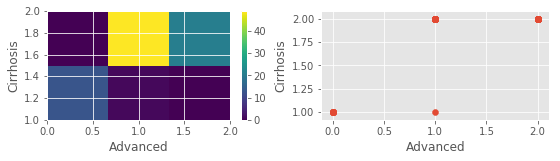

In [17]:
# Признаки 'Cirrhosis' и 'ChildPugh'

print( np.unique(df_ext['Advanced']) )
print( np.unique(df_ext['Cirrhosis']) )

print( ( len(df_ext[ (df_ext['Cirrhosis'] == 1) &  (df_ext['Advanced'] == 0) ].index),
         len(df_ext[ (df_ext['Cirrhosis'] == 1) &  (df_ext['Advanced'] == 1) ].index) ) )

plt.figure(1)

plt.subplot(121)
plt.rcParams['figure.figsize'] = (9,2)

plt.hist2d(df_ext['Advanced'], df_ext['Cirrhosis'], bins=[3,2]) #, cmap = my_cmap, norm=LogNorm())
plt.xlabel('Advanced')
plt.ylabel('Cirrhosis')
plt.colorbar()

plt.subplot(122)
plt.scatter( np.array(df_ext['Advanced']), np.array(df_ext['Cirrhosis']) )
plt.xlabel('Advanced')
plt.ylabel('\nCirrhosis')

plt.show()


[0 1 2 3]
[0 1 2]
(11, 4, 1, 17)


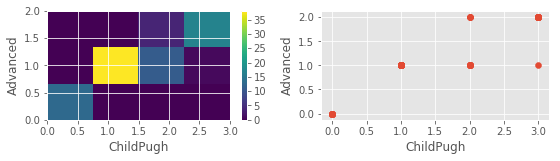

In [18]:
# Признаки 'Advanced' и 'ChildPugh'

print( np.unique(df_ext['ChildPugh']) )
print( np.unique(df_ext['Advanced']) )

print( ( len(df_ext[ (df_ext['Advanced'] == 1) &  (df_ext['ChildPugh'] == 2) ].index),
         len(df_ext[ (df_ext['Advanced'] == 2) &  (df_ext['ChildPugh'] == 2) ].index),
         len(df_ext[ (df_ext['Advanced'] == 1) &  (df_ext['ChildPugh'] == 3) ].index),
         len(df_ext[ (df_ext['Advanced'] == 2) &  (df_ext['ChildPugh'] == 3) ].index) ) 
     )

plt.figure(1)

plt.subplot(121)
plt.rcParams['figure.figsize'] = (12,2)
plt.hist2d(df_ext['ChildPugh'], df_ext['Advanced'], bins=[4,3]) #, norm=LogNorm())
plt.xlabel('ChildPugh')
plt.ylabel('Advanced')
plt.colorbar()

plt.subplot(122)
plt.scatter( np.array(df_ext['ChildPugh']), np.array(df_ext['Advanced']) )
plt.xlabel('ChildPugh')
plt.ylabel('Advanced')

plt.show()

[0 1 2 3]
[1 2]
(13, 1)


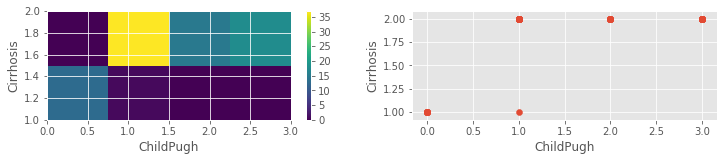

In [19]:
# Признаки 'Cirrhosis' и 'ChildPugh'

print( np.unique(df_ext['ChildPugh']) )
print( np.unique(df_ext['Cirrhosis']) )

print( ( len(df_ext[ (df_ext['Cirrhosis'] == 1) &  (df_ext['ChildPugh'] == 0) ].index),
         len(df_ext[ (df_ext['Cirrhosis'] == 1) &  (df_ext['ChildPugh'] == 1) ].index) ) )

plt.figure(1)

plt.subplot(121)
plt.rcParams['figure.figsize'] = (12,2)
plt.hist2d(df_ext['ChildPugh'], df_ext['Cirrhosis'], bins=[4,2]) #, norm=LogNorm())
plt.xlabel('ChildPugh')
plt.ylabel('Cirrhosis')
plt.colorbar()

plt.subplot(122)
plt.scatter( np.array(df_ext['ChildPugh']), np.array(df_ext['Cirrhosis']) )
plt.xlabel('ChildPugh')
plt.ylabel('Cirrhosis')

plt.show()
